In [1]:
import os    
#os.environ['THEANO_FLAGS'] = "device=gpu1"  
#os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=gpu0,floatX=float32,lib.cnmem=1"
os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=gpu0,floatX=float32"
import theano


import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

np.random.seed(1337) # for reproducibility
from sklearn.cross_validation import train_test_split

from keras.datasets import mnist
from keras.models import Sequential
#from keras.layers import containers
from keras.layers import Input, Dense
#from keras.layers.core import AutoEncoder
from keras.activations import sigmoid
from keras.utils import np_utils

from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import *

nb_classes = 10
nb_hidden_layers = [784, 676, 484, 324, 144, 64, 40]

Using gpu device 0: GeForce 920M (CNMeM is disabled, cuDNN not available)
Using Theano backend.


In [2]:
# the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)
X_train = X_train.astype("float32") / 255.0
X_test = X_test.astype("float32") / 255.0
print(X_train.shape, 'train samples')
print(X_test.shape, 'test samples')

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)



(60000, 784) train samples
(10000, 784) test samples


In [3]:
# Layer-wise pretraining
encoders = []
#X_train_tmp is used for pre-training only
X_train_tmp = np.copy(X_train)  
print(X_train_tmp.shape)

nb_epoch=50
batch_size=256
random_state =6567

(60000, 784)


In [4]:
for i, (n_in, n_out) in enumerate(zip(nb_hidden_layers[:-1], nb_hidden_layers[1:]), start=1):
    print('Training the layer {}: Input {} -> Output {}'.format(i, n_in, n_out))
    
    # this is our input placeholder
    input_img = Input(shape=(n_in,))
    # "encoded" is the encoded representation of the input
    encoded = Dense(n_out, activation='relu')(input_img)
    # "decoded" is the lossy reconstruction of the input
    decoded = Dense(n_in, activation='relu')(encoded)

    # this model maps an input to its reconstruction
    # we will not need a model to reconstruct
    autoencoder = Model(input=input_img, output=decoded)
    
    # this model maps an input to its encoded representation
    # this is the important model for encoding and need to be stacked
    encoder = Model(input=input_img, output=encoded)

    # create a placeholder for an encoded  input
    encoded_input = Input(shape=(n_out,))
    # retrieve the last layer of the autoencoder model
    decoder_layer = autoencoder.layers[-1]
    # create the decoder model
    decoder = Model(input=encoded_input, output=decoder_layer(encoded_input))

    print('compiling...')
    autoencoder.compile(optimizer=Adam(lr=1e-3), loss='categorical_crossentropy')
    print('fiting.pretraining for just few epochs..')
    
    #induce noise in pre-training

    noise_factor = 0.3
    X_train_tmp_noisy = X_train_tmp + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train_tmp.shape) 
    X_train_tmp_noisy = np.clip(X_train_tmp_noisy, 0., 1.)
    print('Shape of noisy input ', X_train_tmp_noisy.shape)

    autoencoder.fit(X_train_tmp_noisy, X_train_tmp,
                nb_epoch=1,
                batch_size=256,
                shuffle=True)
    
    # encode and decode some digits
    # note that we take them from the *test* set
    #encoded_imgs = encoder.predict(X_train_tmp)
    #decoded_imgs = decoder.predict(encoded_imgs)
    
    #SDAE needs new set of training examples with encoded rep for the next stack
    X_train_tmp = encoder.predict(X_train_tmp)
    print('shape of new traintmp while pretraining ',X_train_tmp.shape)
    
    encoders.append(encoder)
    print(encoders)


Training the layer 1: Input 784 -> Output 676
compiling...
fiting.pretraining for just few epochs..
Shape of noisy input  (60000, 784)
Epoch 1/1
60000/60000 [==============================] - 5s - loss: 621.6973     
shape of new traintmp while pretraining  (60000, 676)
Training the layer 2: Input 676 -> Output 484
compiling...
fiting.pretraining for just few epochs..
Shape of noisy input  (60000, 676)
Epoch 1/1
60000/60000 [==============================] - 4s - loss: 1022.6916     
shape of new traintmp while pretraining  (60000, 484)
[<keras.engine.training.Model object at 0x7f17062fd978>, <keras.engine.training.Model object at 0x7f1702b67da0>]
Training the layer 3: Input 484 -> Output 324
compiling...
fiting.pretraining for just few epochs..
Shape of noisy input  (60000, 484)
Epoch 1/1
60000/60000 [==============================] - 2s - loss: 1235.5594     
shape of new traintmp while pretraining  (60000, 324)
[<keras.engine.training.Model object at 0x7f17062fd978>, <keras.engine.t

In [5]:
print(encoders)

[<keras.engine.training.Model object at 0x7f17062fd978>, <keras.engine.training.Model object at 0x7f1702b67da0>, <keras.engine.training.Model object at 0x7f16fdf29b00>, <keras.engine.training.Model object at 0x7f17052928d0>, <keras.engine.training.Model object at 0x7f16fe0b5668>, <keras.engine.training.Model object at 0x7f170522ff98>]


In [6]:
for encoder in encoders:
    #model.add(encoder)
    #x=model.get_weights()
    print(encoder.layers[0])

    #print(encoder.layers[0].get_config())
    print(len(encoder.layers[0].get_weights()))
    
    print(encoder.layers[1])

    #print(encoder.layers[1].get_config())
    print(len(encoder.layers[1].get_weights()))


    ##print(encoder.layers[2]) ---> List Index out of range
    #top_model.layer[2].set_weights(encoder.layers[0].get_weights())
#model.summary()
#print(type(x))
#print(len(x))

0
2
0
2
0
2
0
2
0
2
0
2


In [7]:

print (len(nb_hidden_layers))
print (nb_hidden_layers[0])
print (nb_hidden_layers[1])
print (nb_hidden_layers[2])

print (nb_hidden_layers[-1])
print (nb_hidden_layers[3])

##print (nb_hidden_layers[4])---> List out of range



7
784
676
484
40
324


In [8]:
# Build the top model to Dimension reduction
input_img = Input(shape=(nb_hidden_layers[0],))
top_encoded = Dense(nb_hidden_layers[1], activation='relu')(input_img)
for i in range(len(nb_hidden_layers) - 2) :

    top_encoded = Dense(nb_hidden_layers[i+2], activation='relu')(top_encoded)
    print('i is ',i)
     
#top_encoded = Dense(nb_hidden_layers[3], activation='sigmoid')(top_encoded)

# add the below line classify
top_decoded = Dense(nb_hidden_layers[0], activation='sigmoid')(top_encoded)
top_autoencoder = Model(input=input_img, output=top_decoded)


i is  0
i is  1
i is  2
i is  3
i is  4


In [9]:
# this model maps an input to its encoded representation
top_encoder_only = Model(input=input_img, output=top_encoded)

In [10]:
# create a placeholder for an encoded  input
top_encoded_input = Input(shape=(nb_hidden_layers[-1],))
# retrieve the last layer of the autoencoder model
top_decoder_layer = top_autoencoder.layers[-1]
# create the decoder model
top_decoder_only = Model(input=top_encoded_input, output=top_decoder_layer(top_encoded_input))

In [11]:
print(top_autoencoder.layers[0])
print(len(top_autoencoder.layers[0].get_weights()))

print(top_autoencoder.layers[1])
print(len(top_autoencoder.layers[1].get_weights()))

print(top_autoencoder.layers[2])
print(len(top_autoencoder.layers[2].get_weights()))

print(top_autoencoder.layers[3])
print(len(top_autoencoder.layers[3].get_weights()))

print(top_autoencoder.layers[4])
print(len(top_autoencoder.layers[4].get_weights()))

###index out of range
print(top_autoencoder.layers[6])
print(len(top_autoencoder.layers[6].get_weights()))

print(top_encoder_only)

0
2
2
2
2
2


In [12]:
i=1
for encoder in encoders:
    print('i is ',i)
    # stack the first models encoded layer and set weights
    print(len(encoder.layers[1].get_weights()))
    top_autoencoder.layers[i].set_weights(encoder.layers[1].get_weights())
    print(len(top_autoencoder.layers[i].get_weights()))
    i+=1
    #if i == len(nb_hidden_layers)+1:
    #    break


i is  1
2
2
i is  2
2
2
i is  3
2
2
i is  4
2
2
i is  5
2
2
i is  6
2
2


In [13]:
from sklearn.cross_validation import train_test_split

s_train, s_valid = train_test_split(X_train, test_size=0.3)
#v_train, v_valid = train_test_split(Y_train, test_size=0.3)

noise_factor = 0.3
s_train_noisy = s_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=s_train.shape) 
s_valid_noisy = s_valid + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=s_valid.shape) 

s_train_noisy = np.clip(s_train_noisy, 0., 1.)
s_valid_noisy = np.clip(s_valid_noisy, 0., 1.)

print(s_train_noisy.shape)
print(s_valid_noisy.shape)

(42000, 784)
(18000, 784)


In [14]:
print(top_autoencoder)

top_autoencoder.compile(optimizer=Adam(lr=1e-3), loss='categorical_crossentropy',metrics=['accuracy'])
score = top_autoencoder.evaluate(X_test, X_test, verbose=0)
print('Test score before fine turning:', score[0])
print('Test accuracy before fine turning:', score[1])
callbacks = [
        EarlyStopping(monitor='val_loss', patience=3, verbose=0)
]
top_autoencoder.fit(s_train_noisy, s_train, batch_size=batch_size, nb_epoch=nb_epoch,
                    validation_data=(s_valid_noisy, s_valid),
                    callbacks=callbacks)
score = top_autoencoder.evaluate(X_test, X_test, verbose=0)
print('Test score after fine turning:', score[0])
print('Test accuracy after fine turning:', score[1])

Test score before fine turning: 701.253275
Test accuracy before fine turning: 0.0025
Train on 42000 samples, validate on 18000 samples
Epoch 1/50
42000/42000 [==============================] - 4s - loss: 598.5823 - acc: 0.0030 - val_loss: 571.8149 - val_acc: 0.0065
Epoch 2/50
42000/42000 [==============================] - 4s - loss: 561.6704 - acc: 0.0040 - val_loss: 551.7700 - val_acc: 0.0035
Epoch 3/50
42000/42000 [==============================] - 4s - loss: 549.2304 - acc: 0.0062 - val_loss: 545.2841 - val_acc: 0.0056
Epoch 4/50
42000/42000 [==============================] - 5s - loss: 544.3734 - acc: 0.0026 - val_loss: 543.0502 - val_acc: 0.0016
Epoch 5/50
42000/42000 [==============================] - 4s - loss: 540.5120 - acc: 0.0014 - val_loss: 539.8185 - val_acc: 8.8889e-04
Epoch 6/50
42000/42000 [==============================] - 4s - loss: 537.5870 - acc: 0.0013 - val_loss: 536.4535 - val_acc: 0.0019
Epoch 7/50
42000/42000 [==============================] - 4s - loss: 535.47

In [15]:
train_encoded_imgs = top_encoder_only.predict(X_train,batch_size=batch_size, verbose=1)

59648/60000 [============================>.] - ETA: 0s

In [16]:
print(train_encoded_imgs.shape)

(60000, 40)


In [17]:
test_encoded_imgs = top_encoder_only.predict(X_test,batch_size=batch_size, verbose=1)

 9728/10000 [============================>.] - ETA: 0s

In [18]:
test_decoded_imgs = top_decoder_only.predict(test_encoded_imgs,batch_size=batch_size, verbose=1)

 8960/10000 [=========================>....] - ETA: 0s

In [19]:
print(test_encoded_imgs.shape)

(10000, 40)


In [20]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier()
clf = clf.fit(train_encoded_imgs, Y_train)

In [21]:
y_pred = clf.predict(test_encoded_imgs)

In [22]:
num=len(test_encoded_imgs)
r=0
w=0
wrngclassidx=[]
#y_test = np.ravel(y_test)
for i in range(num):
        #print ('y_pred ',y_pred[i])
        #print ('labels ',labels[i])
        #without the use of all() returns error truth value of an array with more than one element is ambiguous
        #if y_pred[i].all() == labels[i].all():
        if np.array_equal(y_pred[i],Y_test[i]):
            r+=1
        else:
            w+=1
            wrngclassidx.append(i)
print ("tested ",  num, "digits")
print ("correct: ", r, "wrong: ", w, "error rate: ", float(w)*100/(r+w), "%")
print ("got correctly ", float(r)*100/(r+w), "%")
print (len(wrngclassidx))

tested  10000 digits
correct:  9499 wrong:  501 error rate:  5.01 %
got correctly  94.99 %
501


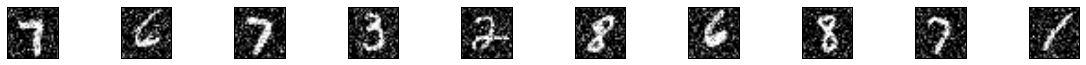

In [23]:
import matplotlib.pyplot as plt
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    #ax = plt.subplot(1, n, i)
    plt.imshow(s_train_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

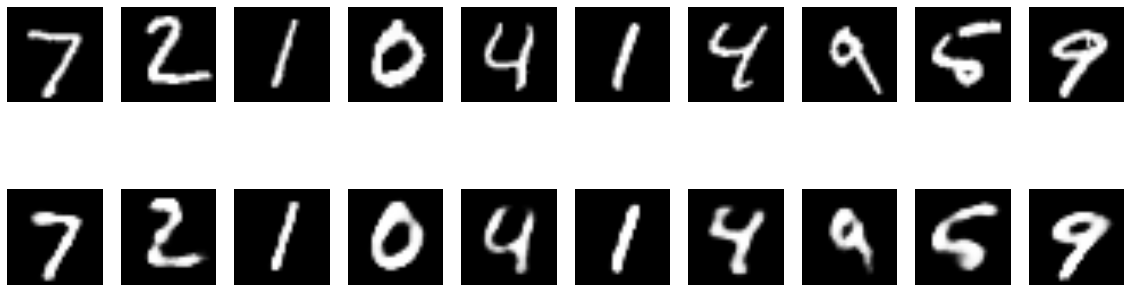

In [24]:

n = 10  # how many digits we will display
plt.figure(figsize=(20, 6))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display encoded
    #ax = plt.subplot(2, n, i + 1 + n)
    #plt.imshow(encoded_imgs[i].reshape(6, 6))
    #plt.gray()
    #ax.get_xaxis().set_visible(False)
    #ax.get_yaxis().set_visible(False)
   
    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(test_decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()